<a href="https://colab.research.google.com/github/TacubaSalva0206/Servicio-social-exoplanetas/blob/main/Versi%C3%B3n_a_redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INICIANDO ANÁLISIS DE EXOPLANETAS KEPLER
Librerías cargadas exitosamente.

CARGA Y EXPLORACIÓN DE DATOS

OPCIÓN A: CLASIFICACIÓN BINARIA (CONFIRMED vs FALSE POSITIVE)

Distribución de Clases:
--------------------------------------------------
FALSE POSITIVE: 5,023 (68.66%)
CONFIRMED: 2,293 (31.34%)


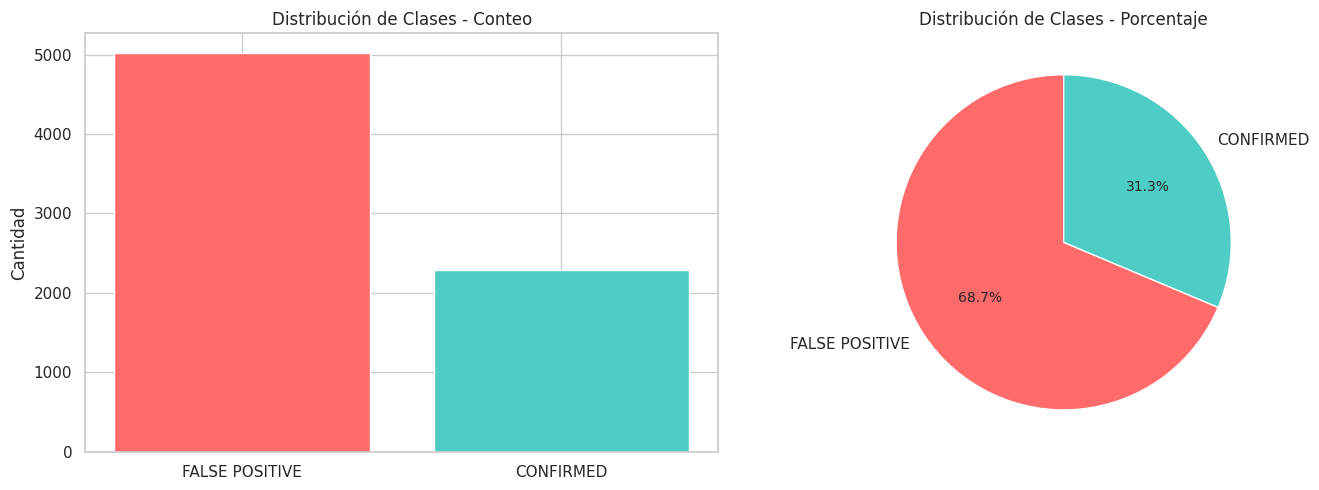


PIPELINE DE PREPROCESAMIENTO OPTIMIZADO

DEFINICIÓN DE MODELOS - REDES NEURONALES

Entrenando: Red Neuronal (Normal)

Entrenando: Red Neuronal (Regularizada)

RESULTADOS DE REDES NEURONALES:
                     Modelo  CV Accuracy  Train Accuracy  Test Accuracy  F1-Score
      Red Neuronal (Normal)       0.9145          0.9924         0.9157    0.9147
Red Neuronal (Regularizada)       0.9119          0.9289         0.9194    0.9179

MATRICES DE CONFUSIÓN - REDES NEURONALES


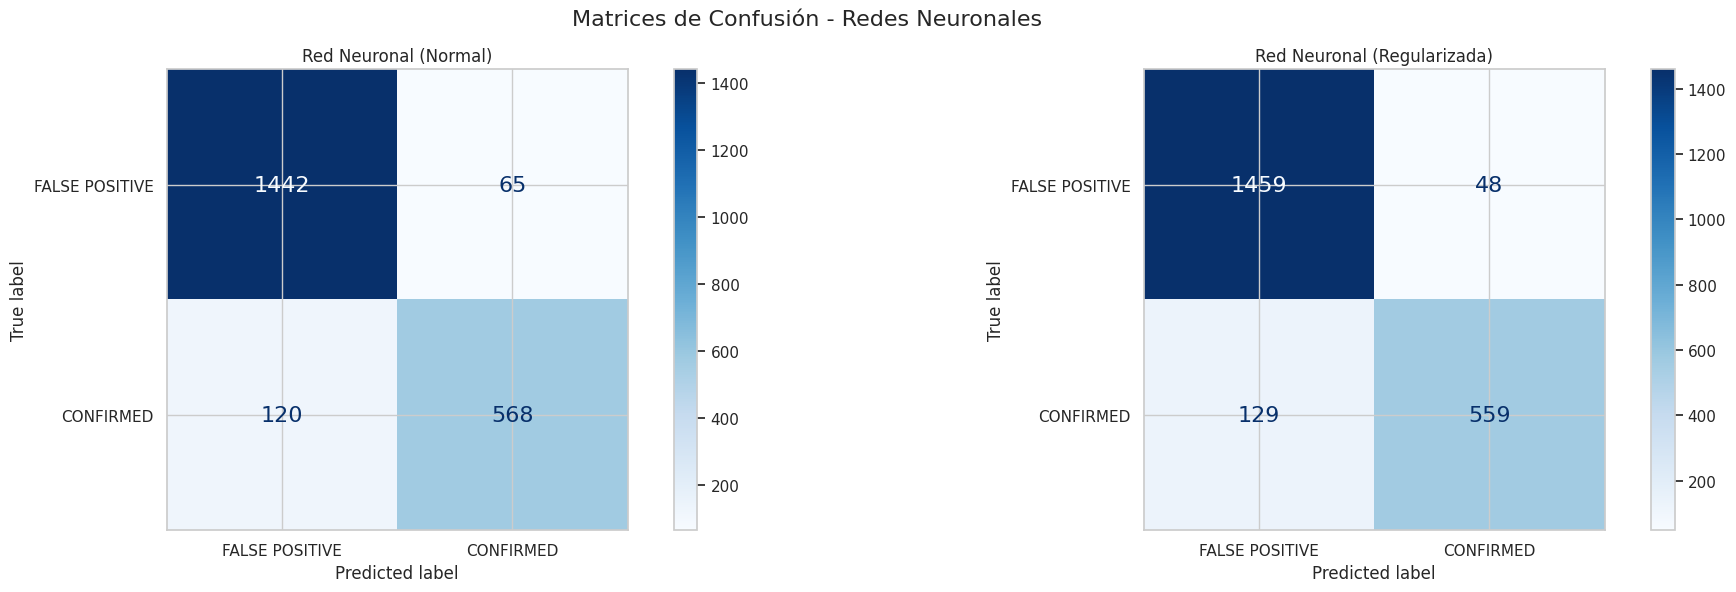


CURVAS DE APRENDIZAJE - REDES NEURONALES


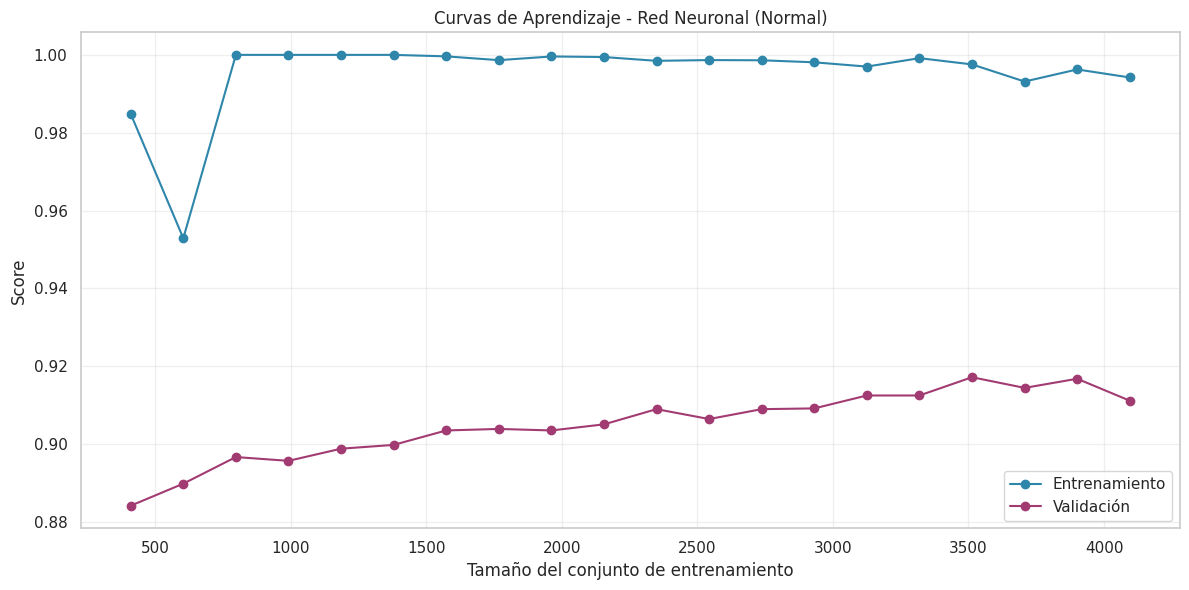

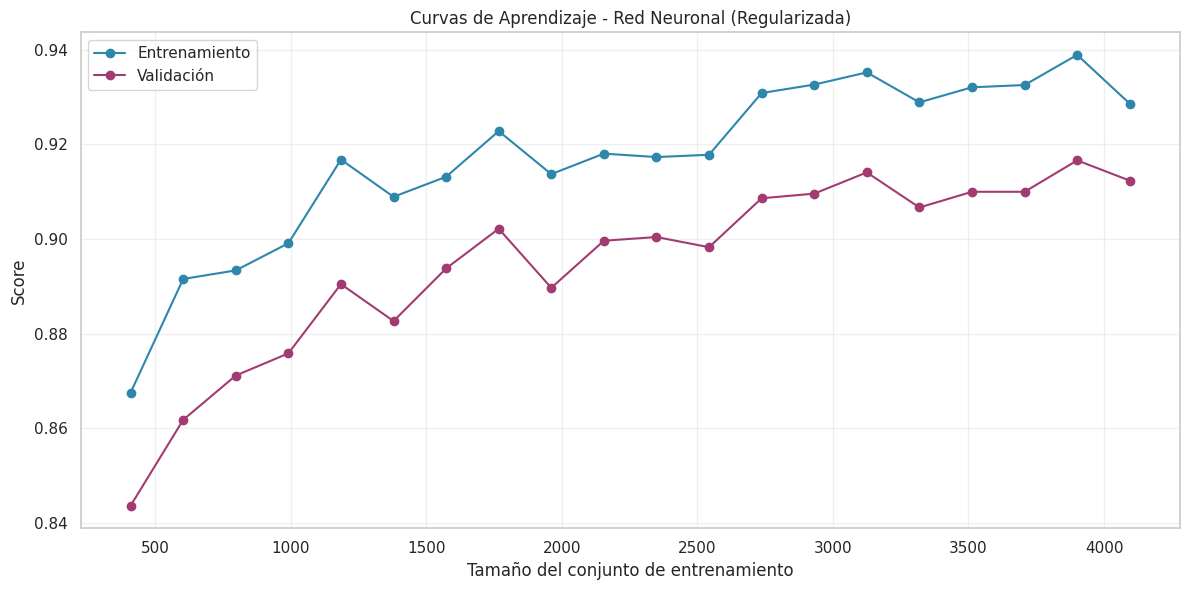


CONCLUSIONES
MEJOR MODELO: Red Neuronal (Regularizada)
Accuracy: 0.9194
F1-Score: 0.9179


In [5]:
print("=" * 80)
print("INICIANDO ANÁLISIS DE EXOPLANETAS KEPLER")
print("=" * 80)

# =============================================================================
# LIBRERÍAS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10
print("Librerías cargadas exitosamente.")

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================
def print_section(title):
    print(f"\n{'='*80}")
    print(f"{title}")
    print('='*80)

def analyze_class_distribution(y, title="Distribución de Clases"):
    class_counts = y.value_counts()
    class_percentages = y.value_counts(normalize=True) * 100

    print(f"\n{title}:")
    print("-" * 50)
    for class_name, count, percentage in zip(class_counts.index, class_counts.values, class_percentages.values):
        label = {0: 'FALSE POSITIVE', 1: 'CONFIRMED'}.get(class_name, str(class_name))
        print(f"{label}: {count:,} ({percentage:.2f}%)")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    colors = ['#FF6B6B', '#4ECDC4']

    ax1.bar(range(len(class_counts)), class_counts.values, color=colors[:len(class_counts)])
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(['FALSE POSITIVE', 'CONFIRMED'][:len(class_counts)])
    ax1.set_ylabel('Cantidad')
    ax1.set_title('Distribución de Clases - Conteo')

    ax2.pie(class_counts.values, labels=['FALSE POSITIVE', 'CONFIRMED'][:len(class_counts)],
            autopct='%1.1f%%', colors=colors[:len(class_counts)], startangle=90)
    ax2.set_title('Distribución de Clases - Porcentaje')

    plt.tight_layout()
    plt.show()
    return class_counts

def plot_learning_curves(model, X, y, cv=5, title="Curvas de Aprendizaje"):
    train_sizes = np.linspace(0.1, 1.0, 20)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='accuracy', shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#2E86AB', label='Entrenamiento')
    plt.plot(train_sizes, val_mean, 'o-', color='#A23B72', label='Validación')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 2. CARGA Y EXPLORACIÓN DE DATOS
# =============================================================================
print_section("CARGA Y EXPLORACIÓN DE DATOS")

df = pd.read_csv("cumulative.csv")
df_cleaned = df.copy()

cols_to_drop = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition',
    'koi_tce_delivname', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
    'koi_fpflag_co', 'koi_fpflag_ec', 'koi_model_snr', 'koi_tce_plnt_num'
]
df_cleaned = df_cleaned.drop(columns=[c for c in cols_to_drop if c in df_cleaned.columns])
df_cleaned = df_cleaned.dropna(subset=['koi_disposition'])

print("\nOPCIÓN A: CLASIFICACIÓN BINARIA (CONFIRMED vs FALSE POSITIVE)")
df_cleaned = df_cleaned[df_cleaned['koi_disposition'] != 'CANDIDATE']

disposition_mapping = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
df_cleaned['koi_disposition'] = df_cleaned['koi_disposition'].map(disposition_mapping)
target_names = ['FALSE POSITIVE', 'CONFIRMED']

missing_fractions = df_cleaned.isnull().mean()
cols_to_drop_missing = missing_fractions[missing_fractions > 0.5].index
df_cleaned = df_cleaned.drop(columns=cols_to_drop_missing)

X = df_cleaned.drop('koi_disposition', axis=1).select_dtypes(include=np.number)
y = df_cleaned['koi_disposition']
analyze_class_distribution(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =============================================================================
# 4. PIPELINE
# =============================================================================
print_section("PIPELINE DE PREPROCESAMIENTO OPTIMIZADO")

preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('selector', SelectKBest(mutual_info_classif, k=30)),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# =============================================================================
# 5. MODELOS: REDES NEURONALES
# =============================================================================
print_section("DEFINICIÓN DE MODELOS - REDES NEURONALES")

models = {
    "Red Neuronal (Normal)": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=1000
    ),
    "Red Neuronal (Regularizada)": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.001,
        batch_size=64,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        max_iter=1000,
        random_state=42
    )
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
detailed_results = {}

for name, model in models.items():
    print(f"\nEntrenando: {name}")
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=cv_strategy, scoring='accuracy')
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)

    results.append({
        'Modelo': name,
        'CV Accuracy': np.mean(cv_scores),
        'Train Accuracy': model.score(X_train_processed, y_train),
        'Test Accuracy': model.score(X_test_processed, y_test),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })
    detailed_results[name] = {'model': model, 'y_pred': y_pred}

results_df = pd.DataFrame(results)
print("\nRESULTADOS DE REDES NEURONALES:")
print(results_df.to_string(index=False, float_format='%.4f'))

# =============================================================================
# 8. MATRICES DE CONFUSIÓN (SOLO REDES NEURONALES)
# =============================================================================
print_section("MATRICES DE CONFUSIÓN - REDES NEURONALES")

fig, axes = plt.subplots(1, len(detailed_results), figsize=(10 * len(detailed_results), 6))
if len(detailed_results) == 1:
    axes = [axes]

for idx, (name, model_info) in enumerate(detailed_results.items()):
    y_pred = model_info['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}', fontsize=12)
    for text in axes[idx].texts:
        text.set_fontsize(16)

plt.suptitle('Matrices de Confusión - Redes Neuronales', fontsize=16)
plt.tight_layout()
plt.show()

# =============================================================================
# 9. CURVAS DE APRENDIZAJE
# =============================================================================
print_section("CURVAS DE APRENDIZAJE - REDES NEURONALES")

for name, model_info in detailed_results.items():
    plot_learning_curves(model_info['model'], X_train_processed, y_train,
                         title=f"Curvas de Aprendizaje - {name}")

# =============================================================================
# 10. CONCLUSIONES
# =============================================================================
print_section("CONCLUSIONES")

best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"MEJOR MODELO: {best_model['Modelo']}")
print(f"Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")


INICIANDO ANÁLISIS DE EXOPLANETAS KEPLER
Librerías cargadas exitosamente.

CARGA Y EXPLORACIÓN DE DATOS
Error: El archivo 'cumulative (2).csv' no se encontró.

LIMPIEZA Y PREPARACIÓN DE DATOS
Eliminadas 13 columnas de metadatos

OPCIÓN A: CLASIFICACIÓN BINARIA (CONFIRMED vs FALSE POSITIVE)
Eliminando 2,248 registros CANDIDATE del dataset
Eliminadas 2 columnas con >50% valores nulos
Dataset final: 34 características, 7,316 observaciones

Distribución de Clases:
--------------------------------------------------
FALSE POSITIVE: 5,023 (68.66%)
CONFIRMED: 2,293 (31.34%)


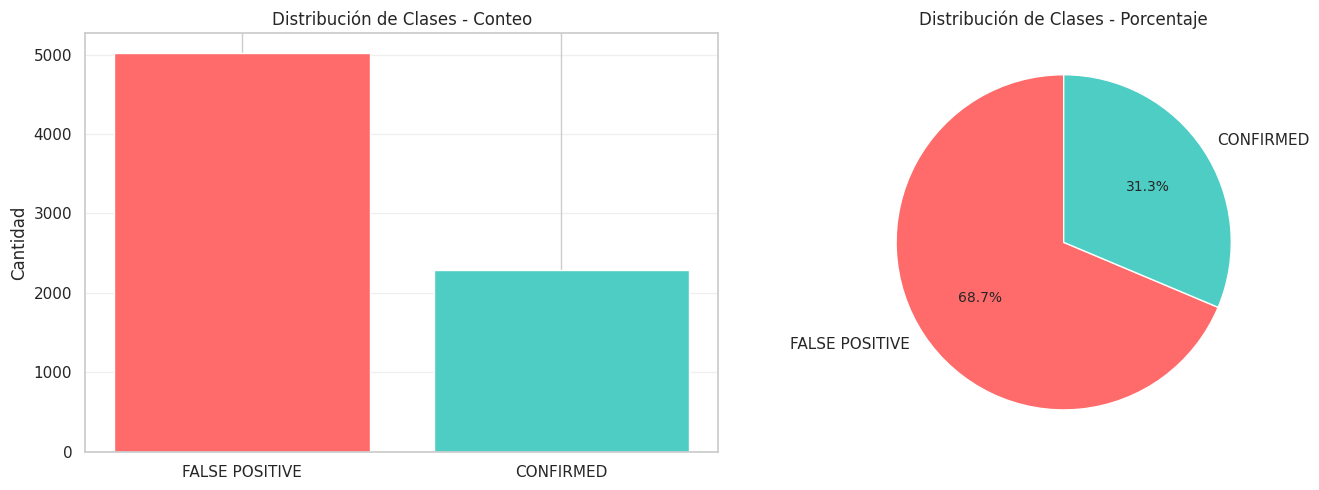

División: 5,121 entrenamiento, 2,195 prueba

PIPELINE DE PREPROCESAMIENTO OPTIMIZADO
Análisis del dataset:
  Muestras: 5,121
  Características: 34
  Clases: 2
  Relación muestras/características: 150.6
  Dataset balanceado → usando 70% de características
  Problema binario → ajustando a 20
  RESULTADO: 20 características seleccionadas

Pipeline aplicado exitosamente:
  Características originales: 34
  Características seleccionadas: 20
  Reducción: 41.2%

Top 15 características más importantes:
          Feature  Selection_Score
         koi_prad           0.1832
   koi_steff_err1           0.1736
   koi_steff_err2           0.1723
    koi_prad_err1           0.1525
koi_duration_err2           0.1521
    koi_prad_err2           0.1518
koi_duration_err1           0.1495
    koi_srad_err1           0.1393
   koi_slogg_err2           0.1192
       koi_period           0.1184
 koi_time0bk_err1           0.1168
   koi_slogg_err1           0.1152
 koi_time0bk_err2           0.1135
       koi_

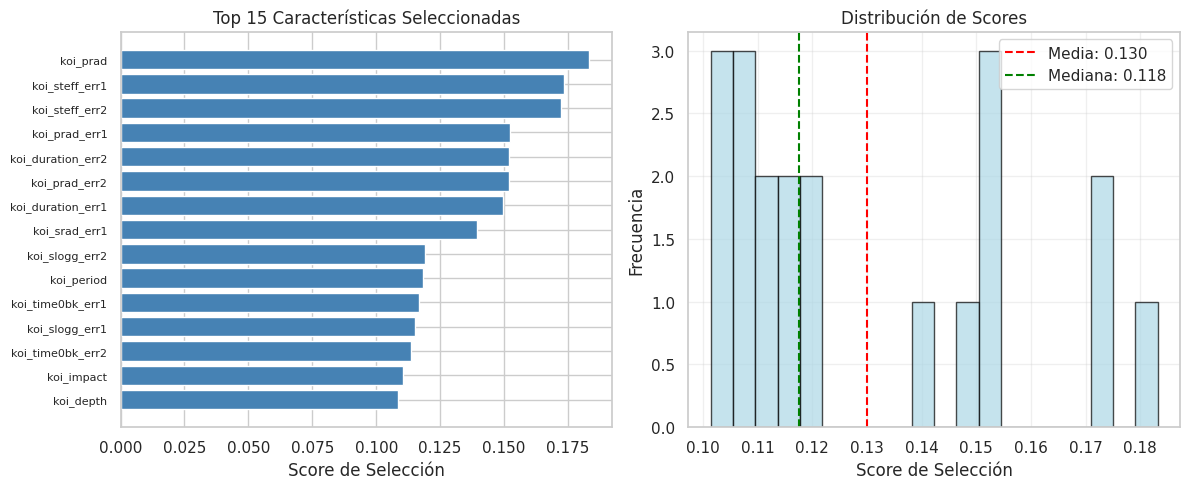


DEFINICIÓN DE MODELOS
Modelos definidos: 2

EVALUACIÓN COMPARATIVA

Evaluando: Red Neuronal (Normal)
  CV: 0.9170 ± 0.0054
  Test: 0.9239, Gap: 0.0292

Evaluando: Red Neuronal (Regularizada)
  CV: 0.9037 ± 0.0103
  Test: 0.9198, Gap: 0.0083

TABLA COMPARATIVA DE RENDIMIENTO
                     Modelo  CV Accuracy  CV Std  Train Accuracy  Test Accuracy  Overfitting Gap  F1-Score  Kappa    MCC
      Red Neuronal (Normal)       0.9170  0.0054          0.9531         0.9239           0.0292    0.9230 0.8193 0.8208
Red Neuronal (Regularizada)       0.9037  0.0103          0.9281         0.9198           0.0083    0.9184 0.8076 0.8107

ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

MATRICES DE CONFUSIÓN


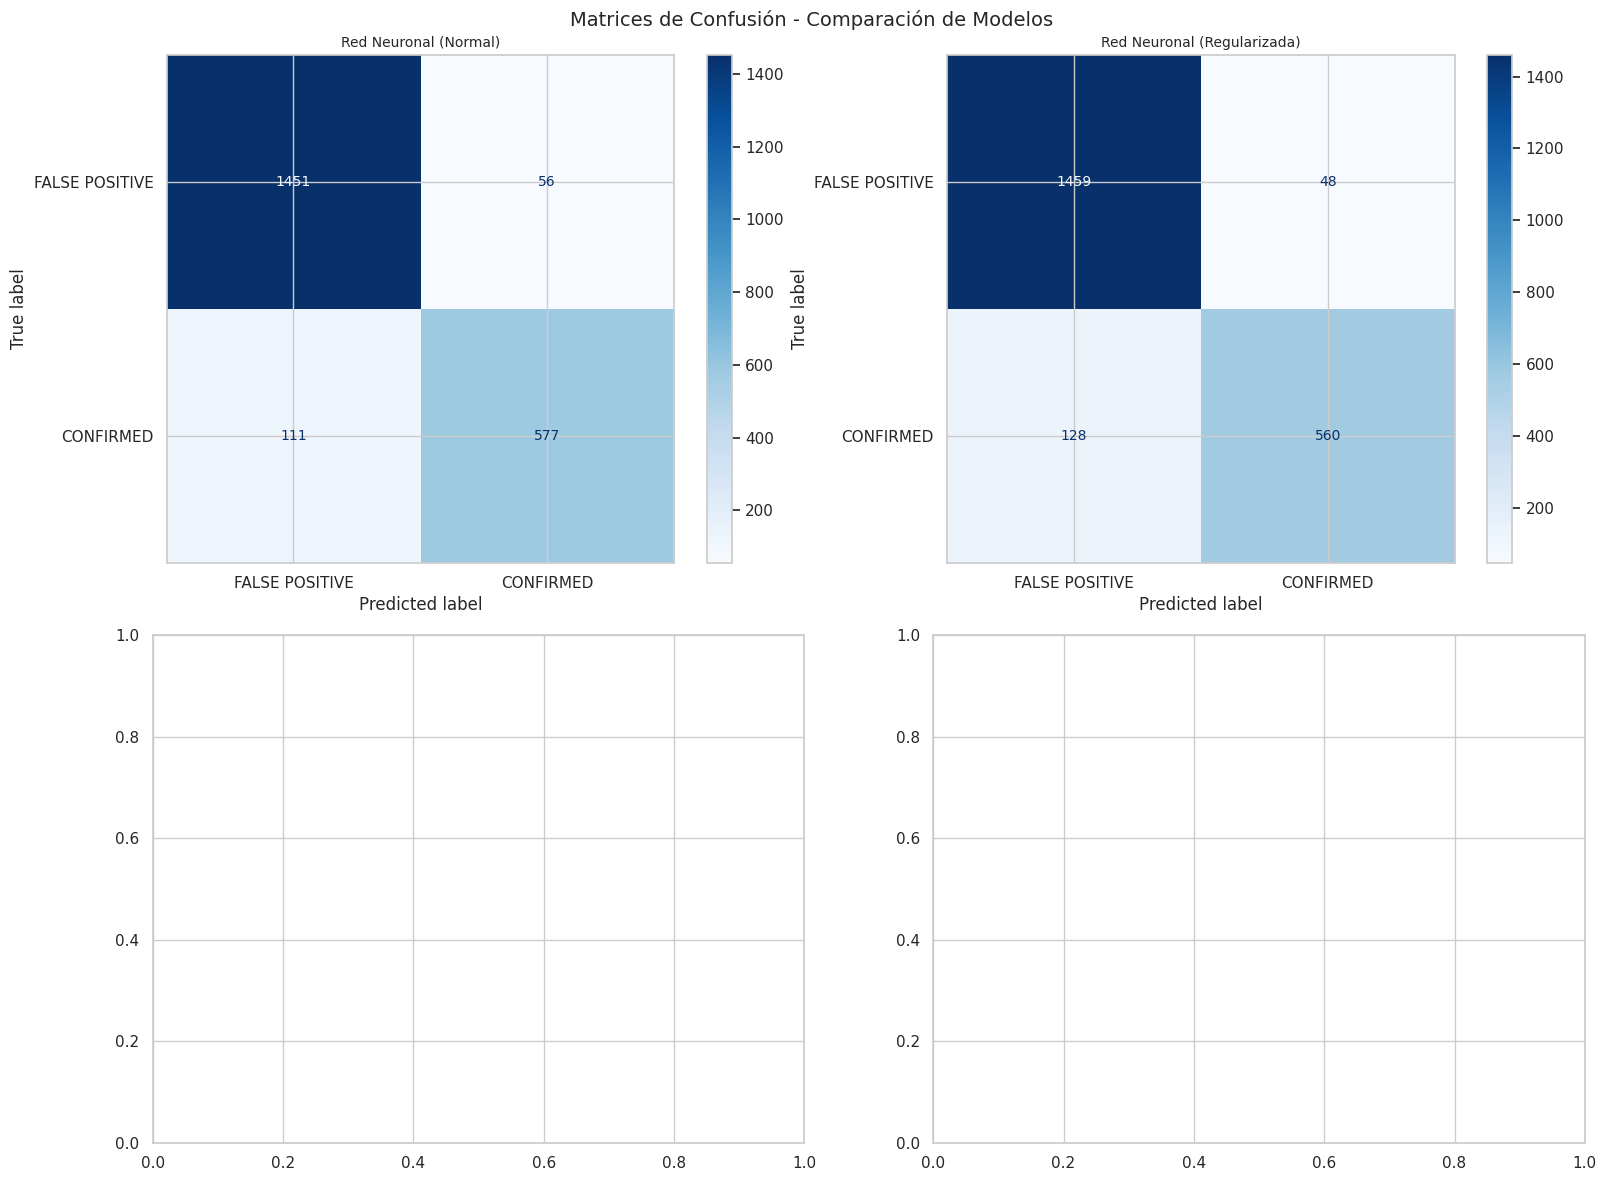


CURVAS DE APRENDIZAJE - DIAGNÓSTICO

Curvas de aprendizaje para: Red Neuronal (Normal)


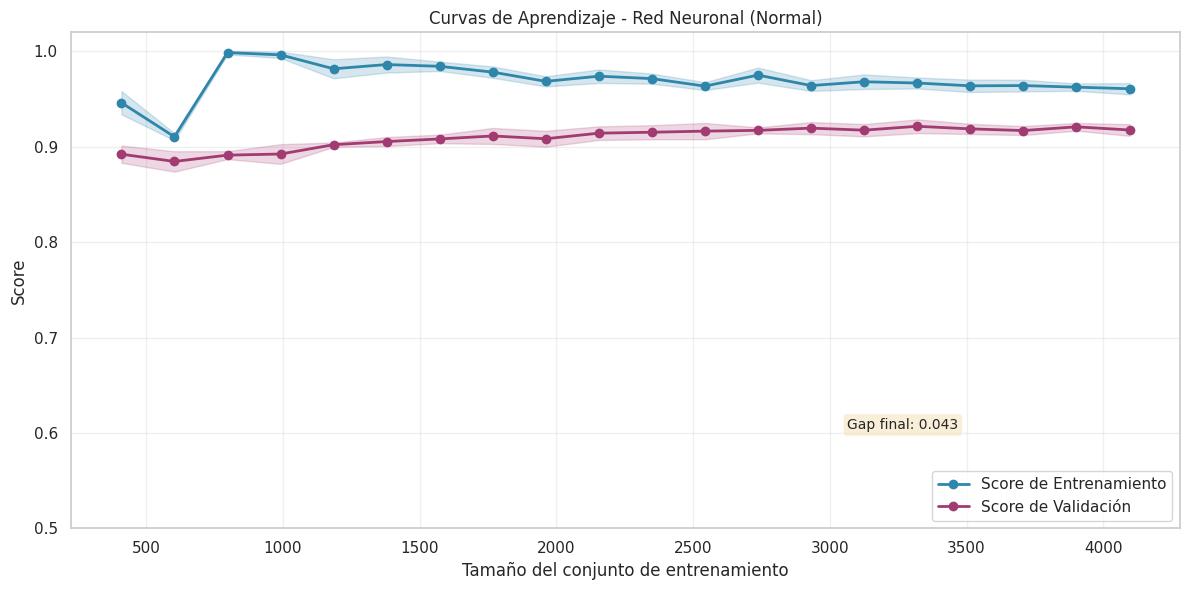

Modelo bien ajustado (gap = 0.043)

Curvas de aprendizaje para: Red Neuronal (Regularizada)


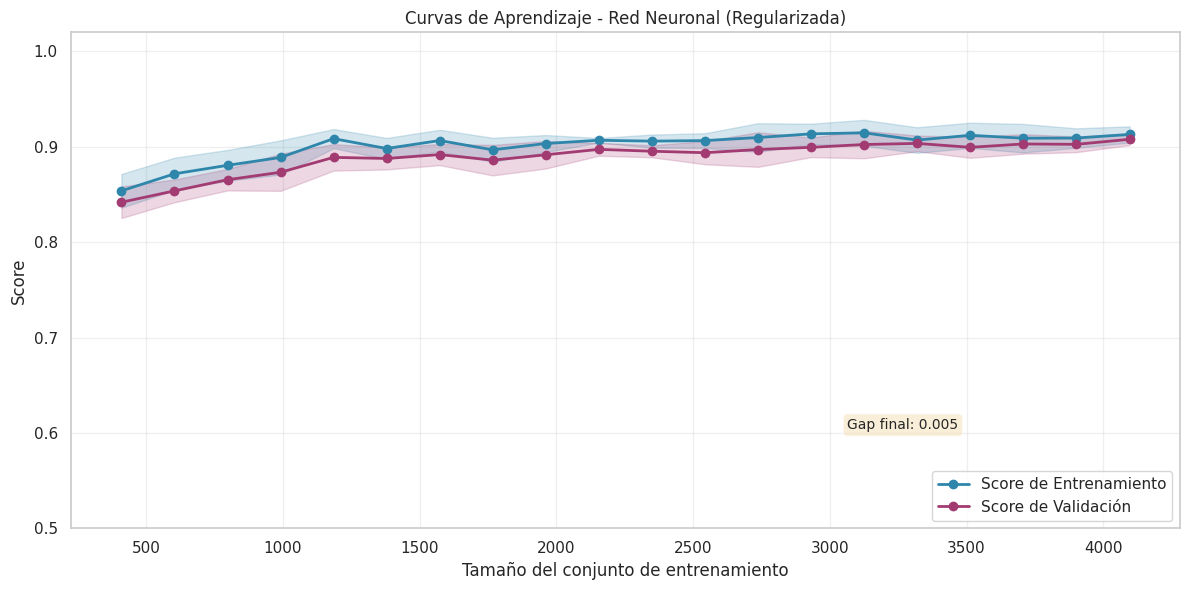

Modelo bien ajustado (gap = 0.005)

CONCLUSIONES Y RECOMENDACIONES
MEJOR MODELO: Red Neuronal (Normal)
  Accuracy: 0.9239
  F1-Score: 0.9230
  Overfitting Gap: 0.0292

RESUMEN DE RENDIMIENTO:
  Red Neuronal (Normal): Test=0.924, Gap=0.029 (BAJO)
  Red Neuronal (Regularizada): Test=0.920, Gap=0.008 (BAJO)


In [6]:
  print("=" * 80)
print("INICIANDO ANÁLISIS DE EXOPLANETAS KEPLER")
print("=" * 80)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos principales
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# Configuración
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10
print("Librerías cargadas exitosamente.")

# =============================================================================
# 1. FUNCIONES AUXILIARES
# =============================================================================

def print_section(title):
    """Imprime un separador de sección formateado"""
    print(f"\n{'='*80}")
    print(f"{title}")
    print('='*80)

def analyze_class_distribution(y, title="Distribución de Clases"):
    """Analiza y visualiza la distribución de clases"""
    class_counts = y.value_counts()
    class_percentages = y.value_counts(normalize=True) * 100

    print(f"\n{title}:")
    print("-" * 50)
    for class_name, count, percentage in zip(class_counts.index, class_counts.values, class_percentages.values):
        label = {0: 'FALSE POSITIVE', 1: 'CONFIRMED'}.get(class_name, str(class_name))
        print(f"{label}: {count:,} ({percentage:.2f}%)")

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    colors = ['#FF6B6B', '#4ECDC4']
    ax1.bar(range(len(class_counts)), class_counts.values, color=colors[:len(class_counts)])
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(['FALSE POSITIVE', 'CONFIRMED'][:len(class_counts)])
    ax1.set_ylabel('Cantidad')
    ax1.set_title('Distribución de Clases - Conteo')
    ax1.grid(axis='y', alpha=0.3)

    ax2.pie(class_counts.values, labels=['FALSE POSITIVE', 'CONFIRMED'][:len(class_counts)],
            autopct='%1.1f%%', colors=colors[:len(class_counts)], startangle=90)
    ax2.set_title('Distribución de Clases - Porcentaje')

    plt.tight_layout()
    plt.show()

    return class_counts

def plot_learning_curves(model, X, y, cv=5, title="Curvas de Aprendizaje"):
    """Genera curvas de aprendizaje para evaluar overfitting/underfitting"""
    train_sizes = np.linspace(0.1, 1.0, 20)

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='accuracy', shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(12, 6))

    plt.plot(train_sizes, train_mean, 'o-', color='#2E86AB', label='Score de Entrenamiento', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#2E86AB')

    plt.plot(train_sizes, val_mean, 'o-', color='#A23B72', label='Score de Validación', linewidth=2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#A23B72')

    gap = train_mean[-1] - val_mean[-1]
    plt.text(0.7, 0.2, f'Gap final: {gap:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 1.02)
    plt.tight_layout()
    plt.show()

    # Diagnóstico
    if gap > 0.05:
        print(f"OVERFITTING detectado (gap = {gap:.3f})")
    elif val_mean[-1] < 0.7:
        print(f"UNDERFITTING detectado (score validación = {val_mean[-1]:.3f})")
    else:
        print(f"Modelo bien ajustado (gap = {gap:.3f})")

def feature_importance_analysis(model, feature_names, top_n=15):
    """Analiza y visualiza la importancia de características"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(12, 6))
        plt.title(f'Top {top_n} Características Más Importantes')
        plt.bar(range(top_n), importances[indices], color='steelblue')
        plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.ylabel('Importancia')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        return pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': importances[indices]
        })

# =============================================================================
# 2. CARGA Y EXPLORACIÓN DE DATOS
# =============================================================================
print_section("CARGA Y EXPLORACIÓN DE DATOS")

try:
    df = pd.read_csv("cumulative (2).csv")
    print(f"Archivo CSV cargado exitosamente.")
    print(f"Dimensiones del dataset: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

except FileNotFoundError:
    print("Error: El archivo 'cumulative (2).csv' no se encontró.")
    exit()

# =============================================================================
# 3. LIMPIEZA Y PREPARACIÓN DE DATOS
# =============================================================================
print_section("LIMPIEZA Y PREPARACIÓN DE DATOS")

# Columnas a eliminar (metadatos e identificadores)
cols_to_drop = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition',
    'koi_tce_delivname', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
    'koi_fpflag_co', 'koi_fpflag_ec', 'koi_model_snr', 'koi_tce_plnt_num'
]

df_cleaned = df.copy()
existing_cols = [col for col in cols_to_drop if col in df_cleaned.columns]
df_cleaned = df_cleaned.drop(columns=existing_cols)
df_cleaned = df_cleaned.dropna(subset=['koi_disposition'])
print(f"Eliminadas {len(existing_cols)} columnas de metadatos")

# Manejo de valores infinitos
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# OPCIÓN A: CLASIFICACIÓN BINARIA - ELIMINAR CANDIDATES
print("\nOPCIÓN A: CLASIFICACIÓN BINARIA (CONFIRMED vs FALSE POSITIVE)")
candidates_count = (df_cleaned['koi_disposition'] == 'CANDIDATE').sum()
print(f"Eliminando {candidates_count:,} registros CANDIDATE del dataset")
df_cleaned = df_cleaned[df_cleaned['koi_disposition'] != 'CANDIDATE']

# Mapeo de la variable objetivo (binario)
disposition_mapping = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
df_cleaned['koi_disposition'] = df_cleaned['koi_disposition'].map(disposition_mapping)
target_names = ['FALSE POSITIVE', 'CONFIRMED']

# Eliminar columnas con muchos valores faltantes
missing_fractions = df_cleaned.isnull().mean()
cols_to_drop_missing = missing_fractions[missing_fractions > 0.5].index
df_cleaned = df_cleaned.drop(columns=cols_to_drop_missing)
print(f"Eliminadas {len(cols_to_drop_missing)} columnas con >50% valores nulos")

# Preparación final
X = df_cleaned.drop('koi_disposition', axis=1).select_dtypes(include=np.number)
y = df_cleaned['koi_disposition']
feature_names = X.columns.tolist()

print(f"Dataset final: {X.shape[1]} características, {X.shape[0]:,} observaciones")

# Análisis de distribución de clases
class_distribution = analyze_class_distribution(y)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"División: {X_train.shape[0]:,} entrenamiento, {X_test.shape[0]:,} prueba")

# =============================================================================
# 4. PIPELINE DE PREPROCESAMIENTO OPTIMIZADO
# =============================================================================
print_section("PIPELINE DE PREPROCESAMIENTO OPTIMIZADO")

def determine_optimal_k(X, y):
    """Determina el número óptimo de características basado en el dataset"""
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    samples_per_feature = n_samples / n_features

    print(f"Análisis del dataset:")
    print(f"  Muestras: {n_samples:,}")
    print(f"  Características: {n_features}")
    print(f"  Clases: {n_classes}")
    print(f"  Relación muestras/características: {samples_per_feature:.1f}")

    # Lógica adaptativa
    if samples_per_feature > 100:  # Dataset muy balanceado
        k_optimal = min(int(0.7 * n_features), 80)
        print(f"  Dataset balanceado → usando 70% de características")
    elif samples_per_feature > 50:  # Dataset balanceado
        k_optimal = min(int(0.5 * n_features), 60)
        print(f"  Dataset moderadamente balanceado → usando 50% de características")
    elif samples_per_feature > 20:  # Dataset moderado
        k_optimal = min(int(0.4 * n_features), 40)
        print(f"  Dataset moderado → usando 40% de características")
    else:  # Dataset con muchas características
        k_optimal = min(int(0.3 * n_features), 30)
        print(f"  Muchas características → usando 30% de características")

    # Ajuste para problemas binarios (reducimos un poco)
    if n_classes == 2:
        k_optimal = int(k_optimal * 0.9)
        print(f"  Problema binario → ajustando a {k_optimal}")

    # Límites de seguridad
    k_optimal = max(15, min(k_optimal, n_features, 100))

    print(f"  RESULTADO: {k_optimal} características seleccionadas")
    return k_optimal

# Determinar k óptimo
k_features = determine_optimal_k(X_train, y_train)

# Crear pipeline optimizado
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('selector', SelectKBest(mutual_info_classif, k=k_features)),
    ('scaler', StandardScaler())
])

# Aplicar preprocessing
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Obtener características seleccionadas
selected_mask = preprocessing_pipeline.named_steps['selector'].get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]

print(f"\nPipeline aplicado exitosamente:")
print(f"  Características originales: {len(feature_names)}")
print(f"  Características seleccionadas: {len(selected_features)}")
print(f"  Reducción: {((len(feature_names) - len(selected_features)) / len(feature_names) * 100):.1f}%")

# Análisis de características seleccionadas
selector_scores = preprocessing_pipeline.named_steps['selector'].scores_[selected_mask]
top_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Selection_Score': selector_scores
}).sort_values('Selection_Score', ascending=False)

print(f"\nTop 15 características más importantes:")
print(top_features_df.head(15).to_string(index=False, float_format='%.4f'))

# Estadísticas de los scores
print(f"\nEstadísticas de scores de selección:")
print(f"  Media: {selector_scores.mean():.4f}")
print(f"  Mediana: {np.median(selector_scores):.4f}")
print(f"  Desviación estándar: {selector_scores.std():.4f}")
print(f"  Rango: {selector_scores.min():.4f} - {selector_scores.max():.4f}")

# Visualización de distribución de scores (opcional)
if len(selected_features) > 10:
    plt.figure(figsize=(12, 5))

    # Subplot 1: Top características
    plt.subplot(1, 2, 1)
    top_15_scores = selector_scores[np.argsort(selector_scores)[::-1][:15]]
    top_15_names = [selected_features[i] for i in np.argsort(selector_scores)[::-1][:15]]

    plt.barh(range(len(top_15_names)), top_15_scores, color='steelblue')
    plt.yticks(range(len(top_15_names)), top_15_names, fontsize=8)
    plt.xlabel('Score de Selección')
    plt.title('Top 15 Características Seleccionadas')
    plt.gca().invert_yaxis()

    # Subplot 2: Distribución de scores
    plt.subplot(1, 2, 2)
    plt.hist(selector_scores, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
    plt.axvline(selector_scores.mean(), color='red', linestyle='--',
                label=f'Media: {selector_scores.mean():.3f}')
    plt.axvline(np.median(selector_scores), color='green', linestyle='--',
                label=f'Mediana: {np.median(selector_scores):.3f}')
    plt.xlabel('Score de Selección')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. DEFINICIÓN DE MODELOS
# =============================================================================
print_section("DEFINICIÓN DE MODELOS")

models = {
    "Red Neuronal (Normal)": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=1000
    ),
    "Red Neuronal (Regularizada)": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.001,
        batch_size=64,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        max_iter=1000,
        random_state=42
    )
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Modelos definidos: {len(models)}")

# =============================================================================
# 6. EVALUACIÓN DE MODELOS
# =============================================================================
print_section("EVALUACIÓN COMPARATIVA")

results = []
detailed_results = {}

for name, model in models.items():
    print(f"\nEvaluando: {name}")

    # Validación cruzada
    cv_scores = cross_val_score(model, X_train_processed, y_train,
                                cv=cv_strategy, scoring='accuracy', n_jobs=-1)

    # Entrenamiento y evaluación
    model.fit(X_train_processed, y_train)
    train_score = model.score(X_train_processed, y_train)
    test_score = model.score(X_test_processed, y_test)
    gap = train_score - test_score

    # Métricas adicionales
    y_pred = model.predict(X_test_processed)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    results.append({
        'Modelo': name,
        'CV Accuracy': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Train Accuracy': train_score,
        'Test Accuracy': test_score,
        'Overfitting Gap': gap,
        'F1-Score': f1_weighted,
        'Kappa': kappa,
        'MCC': mcc
    })

    detailed_results[name] = {'model': model, 'y_pred': y_pred, 'cv_scores': cv_scores}

    print(f"  CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Test: {test_score:.4f}, Gap: {gap:.4f}")

results_df = pd.DataFrame(results)
print("\nTABLA COMPARATIVA DE RENDIMIENTO")
print("="*80)
print(results_df.to_string(index=False, float_format='%.4f'))

# =============================================================================
# 7. ANÁLISIS DE CARACTERÍSTICAS MÁS IMPORTANTES
# =============================================================================
print_section("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")

# Analizar el mejor modelo Random Forest
best_rf_model = None
for name, model_info in detailed_results.items():
    if 'Random Forest' in name and hasattr(model_info['model'], 'feature_importances_'):
        if best_rf_model is None or model_info['model'].score(X_test_processed, y_test) > best_rf_model[1]:
            best_rf_model = (model_info['model'], model_info['model'].score(X_test_processed, y_test), name)

if best_rf_model:
    print(f"\nAnalizando importancia para: {best_rf_model[2]}")
    importance_df = feature_importance_analysis(best_rf_model[0], selected_features)
    if importance_df is not None:
        print("\nTop 10 características más importantes:")
        print(importance_df.head(10).to_string(index=False, float_format='%.4f'))

# =============================================================================
# 8. MATRICES DE CONFUSIÓN
# =============================================================================
print_section("MATRICES DE CONFUSIÓN")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, model_info) in enumerate(detailed_results.items()):
    y_pred = model_info['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}', fontsize=10)

plt.suptitle('Matrices de Confusión - Comparación de Modelos', fontsize=14)
plt.tight_layout()
plt.show()

# =============================================================================
# 9. CURVAS DE APRENDIZAJE
# =============================================================================
print_section("CURVAS DE APRENDIZAJE - DIAGNÓSTICO")

for name, model_info in detailed_results.items():
    print(f"\nCurvas de aprendizaje para: {name}")
    plot_learning_curves(model_info['model'], X_train_processed, y_train,
                         title=f"Curvas de Aprendizaje - {name}")

# =============================================================================
# 10. CONCLUSIONES Y RECOMENDACIONES
# =============================================================================
print_section("CONCLUSIONES Y RECOMENDACIONES")

# Encontrar el mejor modelo
best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"MEJOR MODELO: {best_model['Modelo']}")
print(f"  Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"  F1-Score: {best_model['F1-Score']:.4f}")
print(f"  Overfitting Gap: {best_model['Overfitting Gap']:.4f}")

print(f"\nRESUMEN DE RENDIMIENTO:")
for _, row in results_df.iterrows():
    gap_status = "ALTO" if row['Overfitting Gap'] > 0.1 else "MODERADO" if row['Overfitting Gap'] > 0.05 else "BAJO"
    print(f"  {row['Modelo']}: Test={row['Test Accuracy']:.3f}, Gap={row['Overfitting Gap']:.3f} ({gap_status})")